In [53]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

In [54]:
load_dotenv(override=True)

True

# Structured Output

In [55]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the assistant's response met the success criteria")
    user_input_needed: bool = Field(description="True if more input is needed from the user or clarifications or of assistant is stuck")

# State

In [56]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria_met: bool
    feedback_on_work: Optional[str]
    success_criteria: str
    user_input_needed: bool



In [57]:
import nest_asyncio
nest_asyncio.apply()

#to open browser
async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [58]:
#initalize the LLMs
worker_llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro-preview-06-05", temperature=0)
worker_llm_with_tools = worker_llm.bind_tools(tools)

evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro-preview-06-05", temperature=0)
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

In [59]:
def worker(state:State)->State:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
                        You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
                        This is the success criteria:
                        {state['success_criteria']}
                        You should reply either with a question for the user about this assignment, or with your final response.
                        If you have a question for the user, you need to reply by clearly stating your question. An example might be:
                        Question: please clarify whether you want a summary or a detailed answer

                      If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
                      IMPORTANT:
                        - You may only try a specific website once (e.g., google.com, bing.com, xe.com).
                        - If you fail to extract relevant information from a site, DO NOT try the same site again.
                        - Instead, try a different site or source.
                        - If no new sites are available or all have failed, state this and stop gracefully.
                      """
    if state.get('feedback_on_work'):
        system_message += f"""
                            Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
                            Here is the feedback on why this was rejected:
                            {state['feedback_on_work']}
                            With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user.
                            """
    #add in the system message
    found_system_message = False
    messages = state['messages']
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    if not found_system_message:
        messages = [SystemMessage(content=system_message)]+messages
    
    response = worker_llm_with_tools.invoke(messages)
    return {
    "messages": state["messages"] + [{"role": "assistant", "content": response.content}]
}


In [60]:
def worker_router(state:State)->str:
    last_message = state['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"

In [61]:
def format_conversation(messages:List[Any])->str:
    conversation = "Conversation History:\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or"[Tools use]]"
            conversation += f'Assistant: {text}\n'
    return conversation

In [62]:
def evaluator(state:State)->State:
    last_message = state['messages'][-1]

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
and whether more input is needed from the user."""

    user_message = f"""
You are an evaluator reviewing the most recent response from an AI Assistant to determine task completion.

INSTRUCTIONS:
- Provide brief feedback on the Assistant’s final answer.
- Decide if the task's success criteria were met.
- Decide if the Assistant needs more input from the user.
- RESPOND ONLY with valid JSON — do not explain or add commentary.

JSON response format:
{{
  "feedback": "<your feedback>",
  "success_criteria_met": <true or false>,
  "user_input_needed": <true or false>
}}

Conversation History:
{format_conversation(state['messages'])}

Success Criteria:
{state['success_criteria']}

Final Assistant Response:
"{last_message.content}"
"""
    
    if state['feedback_on_work']:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += f'If you are seeing the assistant repeating the same mistakes, then consider responding that user feedback is needed '

    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    #Fallback if keys are missing or eval_result is None
    success = getattr(eval_result, 'success_criteria_met', False)
    needs_input = getattr(eval_result, 'user_input_needed', False)
    feedback = getattr(eval_result, 'feedback', 'No feedback provided')
    print("Evaluation Result:", eval_result)
    new_state = {
            #"messages": [{"role": "assistant", "content": f'Evaluator feedback: {eval_result.feedback}'}],
            "messages": state["messages"] + [{"role": "assistant", "content": f"Evaluator feedback: {getattr(eval_result, 'feedback', 'None')}"}],
            "feedback_on_work": feedback,
            "success_criteria_met": success,
            "user_input_needed": needs_input
             }
    return new_state

In [63]:
def route_based_on_evaluation(state:State)->str:
    if state['success_criteria_met'] or state['user_input_needed']:
        return "END"
    else:
        return "worker"

In [64]:
def clean_messages(messages):
    cleaned = []
    for msg in messages:
        if isinstance(msg, dict):
            cleaned.append(msg)
        elif hasattr(msg, "type") and hasattr(msg, "content"):
            # LangChain AIMessage / HumanMessage / SystemMessage
            role = {
                "ai": "assistant",
                "human": "user",
                "system": "system"
            }.get(getattr(msg, "type", ""), "assistant")
            cleaned.append({"role": role, "content": msg.content})
        else:
            # Fallback
            cleaned.append({"role": "assistant", "content": str(msg)})
    return cleaned


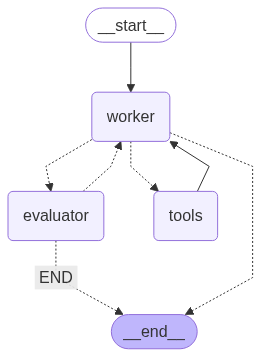

In [65]:
graph_builder = StateGraph(State)

#add nodes
graph_builder.add_node("worker", worker)
graph_builder.add_node("evaluator", evaluator)
graph_builder.add_node("tools", ToolNode(tools=tools))

#Add edges
graph_builder.add_edge(START, "worker")
graph_builder.add_edge("tools","worker")
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"END": END, "worker": "worker"})

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
def make_thread_id()-> str:
    return str(uuid.uuid4())

async def process_message(message, success_criteria, history, thread):
    config = {"configurable": {"thread_id": thread}}
    state = {
        "messages": [{"role": "user", "content": message}],
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }

    result = await graph.ainvoke(state, config=config)

    if "messages" in result:
        result["messages"] = clean_messages(result["messages"])
    user = {"role":"user","content":message}
    reply={"role":"assistant","content":result["messages"][-2]["content"]}
    feedback = {"role":"assistant","content":result["messages"][-1]["content"]}
    return history + [user, reply, feedback]

async def reset():
    return "", "",None, make_thread_id()

In [71]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

demo.launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


Evaluation Result: feedback="The Assistant's response was empty and did not answer the user's question." success_criteria_met=False user_input_needed=True
Evaluation Result: feedback="The assistant failed to provide an answer to the user's question. The response was empty." success_criteria_met=False user_input_needed=True
